**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

4.086088180541992


In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

In [4]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [6]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

In [7]:
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

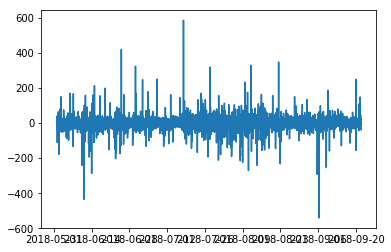

In [8]:
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()
#30min的图

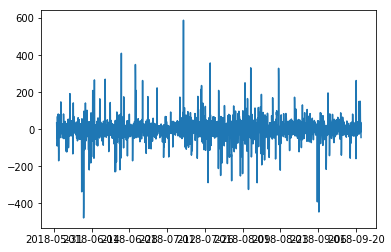

In [9]:
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()
#1H的图

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [5]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [9]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [10]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

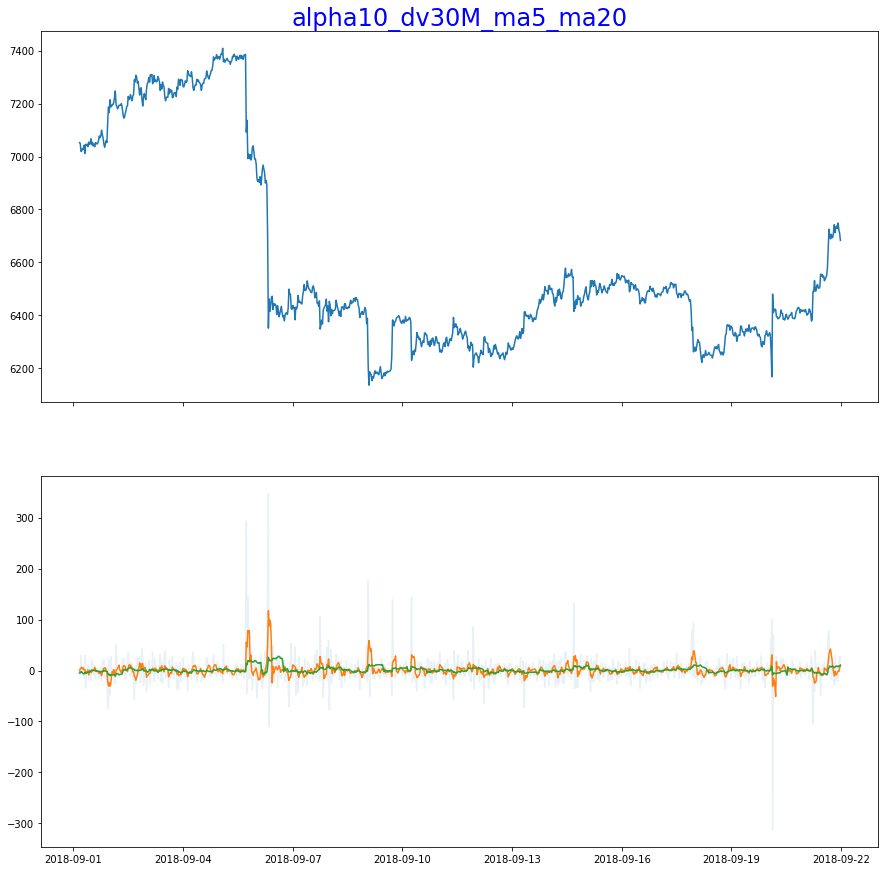

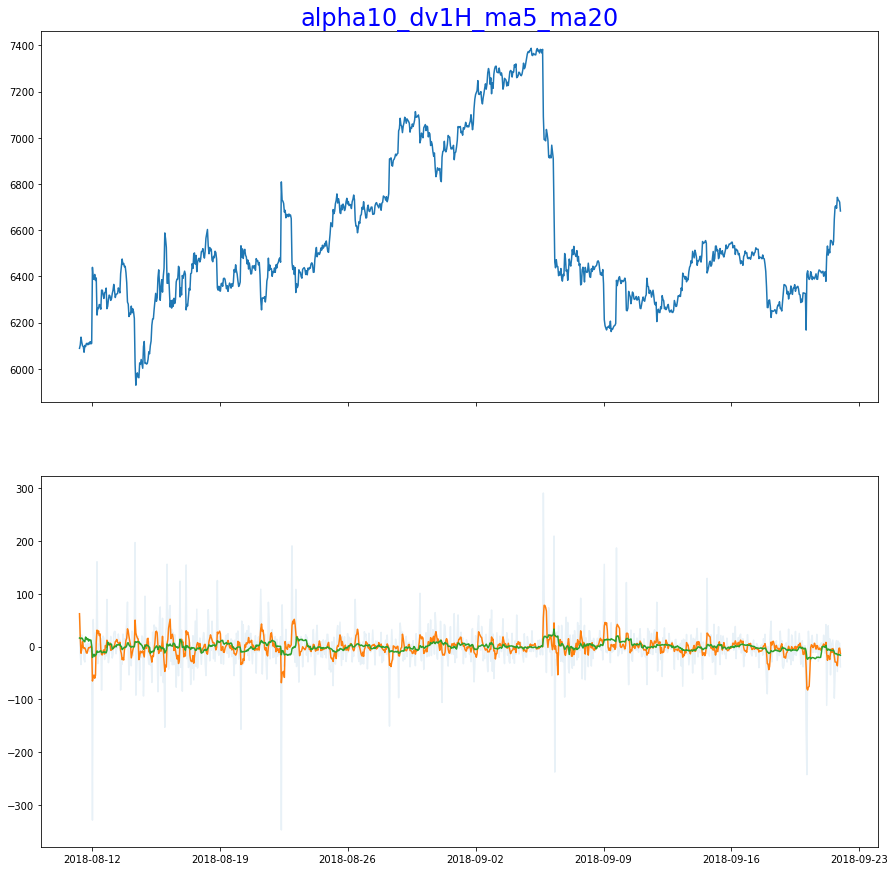

In [11]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [12]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

In [13]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [14]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [15]:
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')

TimingSignal(tdAlpha1, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [16]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [18]:
import warnings

warnings.filterwarnings('ignore')

In [19]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.844726085662842


In [20]:
data1H = Time_dict.set_index('datetime')

In [21]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [22]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [23]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [24]:
Morningstar = dv1H.add_formula('Morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

In [25]:
Morningstar[Morningstar['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
20180615220000,100.0
20180712110000,100.0
20180719060000,100.0
20180809170000,100.0
20180831040000,100.0
20180911020000,100.0
20180918010000,100.0
20180919090000,100.0


In [26]:
dataMorningstar= dv1H.get_ts('Morningstar', date_type='datetime')

In [27]:
dataMorningstar[dataMorningstar['BTCUSDT:binance']==100].index

DatetimeIndex(['2018-06-15 22:00:00', '2018-07-12 11:00:00',
               '2018-07-19 06:00:00', '2018-08-09 17:00:00',
               '2018-08-31 04:00:00', '2018-09-11 02:00:00',
               '2018-09-18 01:00:00', '2018-09-19 09:00:00'],
              dtype='datetime64[ns]', name='trade_date', freq=None)

In [28]:
scatterMorningstarX = dataMorningstar[dataMorningstar['BTCUSDT:binance']==100].index

In [29]:
scatterMorningstarY = data1H.loc[scatterMorningstarX].low-100

In [30]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

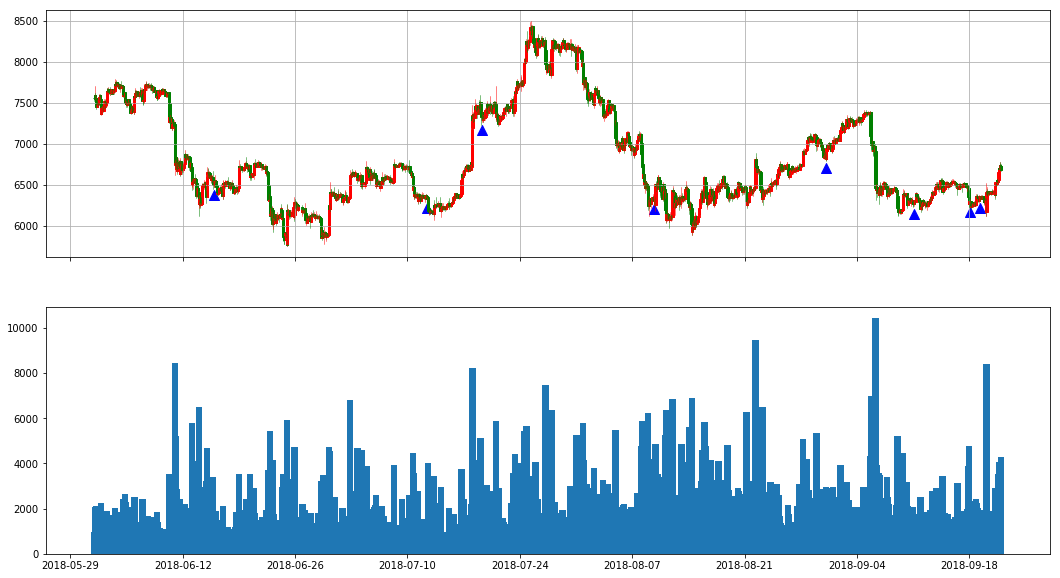

In [32]:
draw_candle(candle, scatterMorningstarX, scatterMorningstarY)

# 调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


# 观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

# 将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


# 一、alpha7因子

In [146]:
import warnings

warnings.filterwarnings('ignore')

时间频率为四小时，品种为比特币期货

In [147]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

8.335721731185913


In [148]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [149]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


引入四十日MA均线指标

In [150]:
ma=dv.add_formula('ma','Ts_Mean(close,40)',add_data=True)

In [151]:
import matplotlib.pyplot as plt
import talib as ta

def plot_chart(close,alpha,ma):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-400:])
    ax.plot(ma.iloc[-400:])
    ax1.plot(alpha.iloc[-400:])
    # plt.savefig('good')
    plt.show()

获取因子alpha7数据

In [152]:
alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)

绘制均线和价格以及因子图

In [153]:
alpha7_plot = dv.get_ts('alpha7_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
ma=dv.get_ts('ma', date_type='datetime')

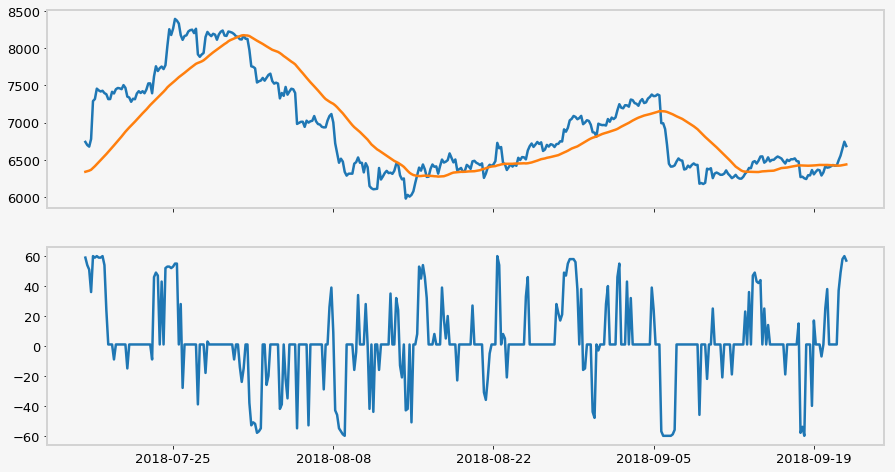

In [154]:
plot_chart(close, alpha7_plot,ma)

# 现象思考：
我们可以将alpha7因子数据分为三大类：

1.大于1

2.等于1

3.小于1

可以发现上升趋势的开始往往因子数据会出现大于1的情况，而在上升趋势中，由于短期价格波动导致因子数据回落到1，但趋势仍旧延续，所以因子数据由高处回落到1时并不意味着趋势结束。我们也会发现在上升趋势中因子数据出现1以下的情况短期趋势终止，盘面出现回调甚至反转。

基于以上发现总结，因子数据为1时代表行情的延续，在盘整情况下，因子出现偏离1的情况意味着趋势的开始，在趋势进行的过程中出现因子数据出现1的偏离方向和趋势方向相反，意味着趋势的结束。

# 信号假设

基于以上现象，我们将出入场信号的确定分为两个步骤：

1.趋势判定：

以四十日均线作为趋势判定线，收盘价在均线之上定义为上升趋势，收盘价在均线之下定义为下降趋势。

2.因子值判定
以偏离1的因子值作为趋势开启状态，以趋势反方向偏离1的因子值作为趋势结束状态。

信号如下：
多单开仓：在上升趋势的情况下，持仓为0并且因子值大于1.

空单开仓：在下降趋势的情况下，持仓为0并且因子值小于1.

平多单：收盘价触及均线或者因子值小于1.

平空单：收盘价触及均线或者因子值大于1.

In [161]:
# 5、设定进出场条件
long = dv.add_formula('long','If((close>ma) && (alpha7_C>1),2,0)', add_data=True)
short = dv.add_formula('short','If((close<ma) && (alpha7_C<1),-2,0)', add_data=True)
closeLong = dv.add_formula('closeLong','If((close<ma) ||(alpha7_C<1),1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If((close>ma) ||(alpha7_C>1),-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [162]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100,sl=100,sp=100)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 11%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 17%


In [163]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               7.497  -12.548    0.804
p-value              0.000    0.000    0.422
mean                 0.042   -0.024    0.003
std                  0.046    0.019    0.046
info_ratio           0.923   -1.261    0.062
skewness             1.226   -1.432    1.445
kurtosis             0.577    1.907    2.646
pct5                 0.001   -0.068   -0.051
pct25                0.007   -0.032   -0.020
pct50                0.018   -0.018   -0.007
pct75                0.058   -0.011    0.014
pct95                0.120   -0.003    0.107
occurance           67.000  100.000  167.000
win_ratio              NaN      NaN    0.401
win_mean/loss_mean     NaN      NaN    1.795


In [164]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               14.634  -12.159    0.631
p-value               0.000    0.000    0.528
mean                  0.053   -0.039    0.002
std                   0.039    0.039    0.060
info_ratio            1.347   -1.017    0.039
skewness              0.602   -2.655   -0.215
kurtosis             -0.435   10.275    1.594
pct5                  0.002   -0.098   -0.077
pct25                 0.019   -0.053   -0.031
pct50                 0.051   -0.029   -0.006
pct75                 0.079   -0.015    0.038
pct95                 0.125   -0.004    0.103
occurance           119.000  144.000  263.000
win_ratio               NaN      NaN    0.452
win_mean/loss_mean      NaN      NaN    1.342


In [165]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               15.861  -15.577    0.959
p-value               0.000    0.000    0.338
mean                  0.049   -0.033    0.003
std                   0.042    0.033    0.055
info_ratio            1.166   -0.999    0.046
skewness              0.835   -2.995    0.155
kurtosis             -0.073   14.141    2.066
pct5                  0.002   -0.085   -0.071
pct25                 0.014   -0.043   -0.027
pct50                 0.037   -0.023   -0.007
pct75                 0.076   -0.013    0.026
pct95                 0.124   -0.004    0.106
occurance           186.000  244.000  430.000
win_ratio               NaN      NaN    0.433
win_mean/loss_mean      NaN      NaN    1.491


# 二、DMI技术因子

In [167]:
import warnings

warnings.filterwarnings('ignore')

时间频率为四小时，品种为比特币期货

In [168]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

8.405540466308594


In [169]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [170]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [171]:
close = dv.get_ts('close',date_type='datetime').dropna()
high = dv.get_ts('close',date_type='datetime').dropna()
low = dv.get_ts('close',date_type='datetime').dropna()

获取因子ADX、DI+、DI-数据

In [172]:
dm1=dv.add_formula('dm1','If((high-Delay(high,1))>0,high-Delay(high,1),0)',add_data=True)

In [173]:
dm2=dv.add_formula('dm2','If((Delay(low,1)-low)>0,Delay(low,1)-low,0)',add_data=True)

In [174]:
dm=dv.add_formula('dm','Max(dm1,dm2)',add_data=True)

In [175]:
tr1=dv.add_formula('TR1','Max(Abs(high-close),Abs(high-Delay(close,1)))',add_data=True)

In [176]:
tr2=dv.add_formula('TR2','Max(Abs(high-close),Abs(low-Delay(close,1)))',add_data=True)

In [177]:
tr=dv.add_formula('TR','Max(TR1,TR2)',add_data=True)

In [178]:
di1=dv.add_formula('DI1','Ts_Mean(dm1,14)*100/Ts_Mean(TR,14)',add_data=True)

In [179]:
di2=dv.add_formula('DI2','Ts_Mean(dm2,14)*100/Ts_Mean(TR,14)',add_data=True)

In [180]:
dx=dv.add_formula('DX','Abs(DI1-DI2)*100/(DI1+DI2)',add_data=True)

In [181]:
adx=dv.add_formula('ADX','Ts_Mean(DX,14)',add_data=True)

绘制DI+、DI-、ADX因子图

In [182]:
import matplotlib.pyplot as plt
import talib as ta

def plot_chart(close,di1,di2,adx):
    fig,(ax,ax1,ax2) = plt.subplots(3,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-450:])
    ax1.plot(di1.iloc[-450:])
    ax1.plot(di2.iloc[-450:])
    ax2.plot(adx.iloc[-450:])
    ax2.hlines(30,adx.index[-450],adx.index[-1])
    # plt.savefig('good')
    plt.show()

In [183]:
close = dv.get_ts('close', date_type='datetime')
di1=dv.get_ts('DI1', date_type='datetime')
di2=dv.get_ts('DI2', date_type='datetime')
adx=dv.get_ts('ADX', date_type='datetime')

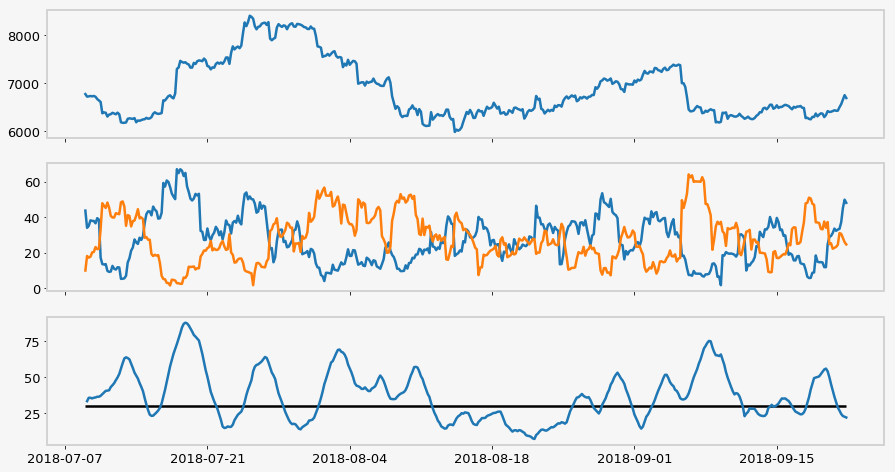

In [184]:
plot_chart(close,di1,di2,adx)

# 现象思考：
DMI指标的研判主要是集中在两个方面，一个方面是分析上升指标+DI、下降指标-DI和平均动向指标ADX之间的关系，另一个方面是对行情的趋势及转势特征的判断。其中，+DI和-DI两条曲线的走势关系是判断能否买卖的信号，ADX则是判断未来行情发展趋势的信号。

1、判断行情趋势
当行情走势由横盘向上发展时，ADX值会不断递增。因此，当ADX值高于前一日时，可以判断当前市场行情仍在维持原有的上升趋势，即价格将继续上涨，如果+DI和﹣DI同时增加，则表明当前上升趋势将十分强劲。

当行情走势进入横盘阶段时，ADX值会不断递减。因此，判断行情时，应结合价格走势（+DI和-DI）走势进行判断。

当行情走势由盘整向下发展时，ADX值也会不断递增。因此，当ADX值高于前一日时，可以判断当前市场行情仍维持原有的下降趋势，即价格将继续下跌，如果+DI和-DI同时减少，则表示当前的跌势将延续。

2、判断行情是否盘整
当市场行情在一定区域内小幅横盘盘整时，ADX值会出现递减情况。当ADX值降至300以下，且呈横向窄幅移动时，可以判断行情为牛皮盘整，上升或下跌趋势不明朗，投资者应以观望为主，不可依据+DI和-DI的交叉信号来买卖。

3、判断行情是否转势
当ADX值在高点由升转跌时，预示行情即将反转。在涨势中的ADX在高点由升转跌，预示涨势即将告一段落；在跌势中的ADX值从高位回落，预示跌势可能停止。

# 信号假设

DMI因子信号判断分为两部分：

一、上升指标+DI和下降指标-DI的研判功能

1、当股价走势向上发展，而同时+DI从下方向上突破-DI时，表明市场上有新多买家进场，为买入信号，如果ADX伴随上升，则预示股价的涨势可能更强劲。

2、当股价走势向下发展时，而同时+DI从上向下突破-DI时，表明市场上做空力量在加强，为卖出信号，如果ADX伴随上升，则预示跌势将加剧。

3、当股价维持某种上升或下降行情时，+DI和﹣DI的交叉突破信号比较准确，但当股价维持盘整时，应将+DI和-DI交叉发出的买卖信号视为无效。

二、平均动向指标ADX的研判功能

ADX为动向值DX的平均数，而DX是根据+DI和-DI两数值的差和对比计算出来的百分比，因此，利用ADX指标将更有效地判断市场行情的发展趋势。

信号如下：
多单开仓：+DI从下方向上突破-DI时，持仓为0并且ADX值高于前一日.

空单开仓：-DI从下方向上突破+DI时，持仓为0并且ADX值高于前一日.

平多单：-DI从下方向上突破+DI.

平空单：+DI从下方向上突破-DI.


In [191]:
# 5、设定进出场条件
long = dv.add_formula('long','If((DI1>DI2) && (ADX>Delay(ADX,1)),2,0)', add_data=True)
short = dv.add_formula('short','If((DI2>DI1) && (ADX>Delay(ADX,1)),-2,0)', add_data=True)
closeLong = dv.add_formula('closeLong','If((DI1<DI2),1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If((DI1>DI2),-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeShort] is overwritten.


In [192]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100,sl=100,sp=100)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 21%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 25%


In [193]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                9.538  -18.665    1.395
p-value               0.000    0.000    0.164
mean                  0.052   -0.027    0.004
std                   0.062    0.020    0.057
info_ratio            0.833   -1.333    0.077
skewness              1.618   -0.808    1.956
kurtosis              1.727    0.526    4.669
pct5                  0.001   -0.063   -0.060
pct25                 0.008   -0.038   -0.029
pct50                 0.024   -0.025   -0.005
pct75                 0.066   -0.009    0.014
pct95                 0.184   -0.002    0.147
occurance           132.000  197.000  329.000
win_ratio               NaN      NaN    0.401
win_mean/loss_mean      NaN      NaN    1.897


In [194]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               17.169  -13.880    2.928
p-value               0.000    0.000    0.004
mean                  0.053   -0.039    0.009
std                   0.045    0.039    0.062
info_ratio            1.190   -0.999    0.146
skewness              0.824   -2.675   -0.031
kurtosis             -0.234    9.706    1.466
pct5                  0.003   -0.099   -0.081
pct25                 0.015   -0.051   -0.026
pct50                 0.042   -0.028    0.001
pct75                 0.085   -0.015    0.045
pct95                 0.150   -0.005    0.123
occurance           209.000  194.000  403.000
win_ratio               NaN      NaN    0.519
win_mean/loss_mean      NaN      NaN    1.382


In [195]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               18.644  -20.686    3.144
p-value               0.000    0.000    0.002
mean                  0.053   -0.033    0.007
std                   0.052    0.031    0.060
info_ratio            1.011   -1.047    0.116
skewness              1.353   -2.898    0.749
kurtosis              1.492   13.818    2.541
pct5                  0.001   -0.081   -0.067
pct25                 0.013   -0.043   -0.029
pct50                 0.036   -0.026   -0.003
pct75                 0.077   -0.013    0.030
pct95                 0.163   -0.002    0.123
occurance           341.000  391.000  732.000
win_ratio               NaN      NaN    0.466
win_mean/loss_mean      NaN      NaN    1.603
